In [1]:
import numpy as np
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

In [2]:
class AdaBoost:

    def __init__(self, n_learners=25):
        self.learners = None
        self.alpha = None
        self.sample_weights = None
        self.n_learners = n_learners
        self.errors = None

    def fit(self, X, y):
        m = X.shape[0]

        self.sample_weights = np.zeros(shape=(self.n_learners, m))
        self.sample_weights[0] = np.ones(shape=m) / m

        self.learners = np.empty(shape=self.n_learners, dtype=object)
        self.alpha = np.zeros(shape=self.n_learners)
        self.errors = np.zeros(shape=self.n_learners)

        for t in range(self.n_learners):
            ht = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            ht.fit(X, y, sample_weight=self.sample_weights[t])
            preds = ht.predict(X)

            err = self.sample_weights[t][(preds != y)].sum()
            alpha = 0.5 * np.log((1 - err) / err)
            self.errors[t] = (preds != y).mean()

            next_weights = self.sample_weights[t] * np.exp(-alpha * y * preds)
            next_weights /= next_weights.sum()

            if t+1 < self.n_learners:
                self.sample_weights[t+1] = next_weights

            self.learners[t] = ht
            self.alpha[t] = alpha

    def predict(self, X):
        preds = np.array([clf.predict(X) for clf in self.learners])
        weighted_majority = np.sign(np.dot(self.alpha, preds))     
        return weighted_majority

In [3]:
X, y = make_gaussian_quantiles(
        n_samples=10,
        n_features=2,
        n_classes=2,
        random_state=12345)
y = y * 2 - 1

In [4]:
N = 8
clf = AdaBoost(n_learners=N)
clf.fit(X, y)
preds = clf.predict(X)
train_err = (preds != y).mean()
print(f'Custom AdaBoost Error: {train_err:.1%}')

Custom AdaBoost Error: 0.0%


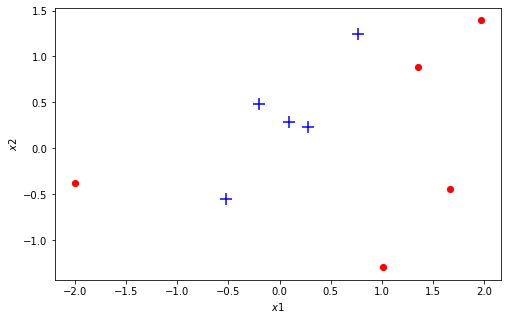

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

markers = ["+" if x != 1 else "." for x in y]
colors = ["b" if x != 1 else "r" for x in y]

for _s, _x, _y, _c in zip(markers, X[:, 0], X[:, 1], colors):
    plt.scatter(_x, _y, marker=_s, c=_c, s=150)

_ = ax.set_xlabel('$x1$')
_ = ax.set_ylabel('$x2$')

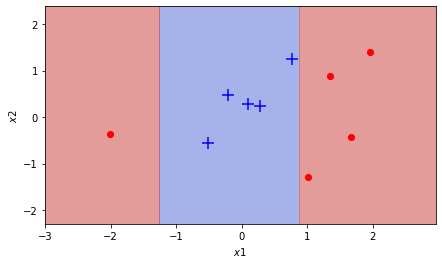

In [7]:
def plot_adaboost(X, y, clf, ax):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 

    Z = Z.reshape(xx.shape)
    fill_colors = ['blue', 'red']
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)

    markers = ["+" if x != 1 else "." for x in y]
    colors = ["b" if x != 1 else "r" for x in y]

    for _s, _x, _y, _c in zip(markers, X[:, 0], X[:, 1], colors):
        ax.scatter(_x, _y, marker=_s, c=_c, s=150)

    ax.set_xlabel('$x1$')
    ax.set_ylabel('$x2$')
   
fig, ax = plt.subplots(figsize=(7, 4))
plot_adaboost(X, y, clf, ax)    

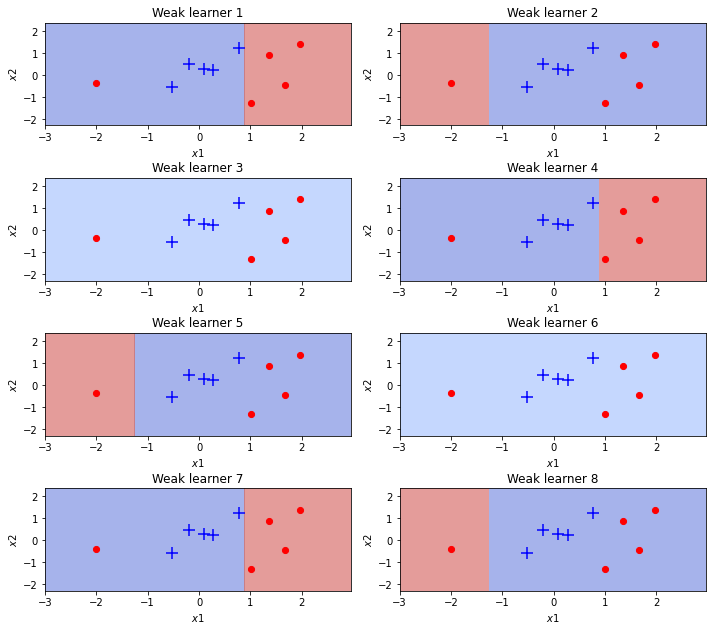

In [8]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

m = 0
for i in range(4):
    for j in range(2):
        axs[i, j].set_title('Weak learner {0}'.format(m + 1))        
        plot_adaboost(X, y, clf.learners[m], axs[i, j])
        m += 1
plt.tight_layout()
plt.subplots_adjust(top=0.85)        